# Implement probabilistic scores for ensemble forecasts
 
Now let's implement the ensemble scores. Please refer to the Dropbox document for their definition. 

1. Spread/Skill ratio: As mentioned in Scher and Messori (2020) there is a right way to do the order of the computations. Read their paragraph on it.
2. CRPS: Try the `properscoring` package. This one should be good.
3. Rank histogram: Try the `rankhistogram` package. No idea if this one is good. If it's ok but requires minor changes, we can consider a pull request. Otherwise, let's just write our own implementation. 

For all three scores:
- Use `xarray` as much as possible. Write a function similar to `src.score.compute_weighted_rmse.py`. 
- Ignore the weighted part at first.
- Create simple synthetic datasets to test extreme cases. E.g. `ensemble = [1, 1, 1]`, `obs=[1]` should result in a CRPS of 0. Think about what good sanity checks are for each score. For the rank histogram, for example, try to build examples that should end up in the shapes from the Dropbox document (overdispersion, underdispersion, etc.)
- Test the three functions with the "real" data from the dropout ensemble.
- Now the weighted part: Because the area of each lat-lon square is not the same but in fact varies with cos(lat), we want to weigh each grid point proportional to its area. This is already implemented for the rmse and acc scores in `src/score.py`. Implement this for the three probabilistic scores and compare to the unweighted scores. They shouldn't be too different. Implementing this for the rank histogram might require some thinking. We can talk about this together.

ToDo:
2. working with full data- Takes too long.
4. creating function to compare different models on CRPS, Spread-skill, RankHistogram. should be simple.

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import matplotlib.pyplot as plt

In [3]:
# # You only need this if you are using a GPU
# os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
# limit_mem()

In [4]:
# tf.compat.v1.disable_eager_execution() #needed
tf.__version__

'2.1.0'

In [5]:
!pwd

/home/garg/WeatherBench/nbs_probabilistic


In [6]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/63-resnet_d3_best.yml'
model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions'

In [ ]:
!python create_dropout_ensemble.py 5 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir}

In [7]:
    args=load_args(exp_id_path)
    exp_id=args['exp_id']
    var_dict=args['var_dict']
    batch_size=args['batch_size']
    output_vars=args['output_vars']
    
    #Question: how to optionally  input data_subsample, norm_subsample, nt_in, dt_in, test_years?
    data_subsample=args['data_subsample']
    norm_subsample=args['norm_subsample']
    nt_in=args['nt_in']
    dt_in=args['dt_in']
    test_years=args['test_years']
    lead_time=args['lead_time']
    

In [8]:
preds=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [9]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 5, time: 32)
Coordinates:
  * member   (member) int64 0 1 2 3 4
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-02T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 ...
    t_850    (member, time, lat, lon) float64 ...

In [10]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])
mean = xr.open_dataarray(f'{model_save_dir}/{exp_id}_mean.nc') 
std = xr.open_dataarray(f'{model_save_dir}/{exp_id}_std.nc')

In [11]:
ds_test= ds.sel(time=slice(test_years[0],test_years[-1]))
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, shuffle=False, load=True,
                 mean=mean, std=std, output_vars=output_vars, data_subsample=data_subsample, norm_subsample=1,
                 nt_in=nt_in, dt_in=1) #important. what are defaults and what to use. Like nt_in?


DG start 16:20:36.777909
DG normalize 16:20:36.792817
DG load 16:20:36.798366
Loading data into RAM
DG done 16:20:57.595864


In [12]:
X,y=dg_test[0]
X.shape, y.shape

((32, 32, 64, 114), (32, 32, 64, 2))

In [13]:
observation=y
observation=observation* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values

In [14]:
observation= xr.Dataset({
    'z_500': xr.DataArray(observation[...,0],
                         dims=['time','lat','lon'],
                         coords={'time':dg_test.data.time.isel(time=slice(None,X.shape[0])),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)
    ,
    't_850': xr.DataArray(observation[...,1],dims=['time','lat','lon'],coords={'time':dg_test.data.time.isel(time=slice(None,X.shape[0])),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)          
})

In [15]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 32)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-02T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (time, lat, lon) float64 5.151e+04 5.151e+04 ... 4.889e+04
    t_850    (time, lat, lon) float64 258.5 258.9 258.9 ... 249.8 249.6 249.3

# Evaluation methods: Spread-skill, CRPS, Rank histogram
check src/score.py.

In [17]:
#Method 1: Evaluating Spread-Skill Ratio (Based on Paper by scher and Messori 2020: Ensemble NN forecasts with SVD)
mean_spread=compute_weighted_meanspread(preds); print(mean_spread)

ensemblemean=preds.mean('member')
mean_rmse=compute_weighted_rmse(observation,ensemblemean); print(mean_rmse)

#spread_skill_ratio=mean_spread/mean_rmse; print(spread_skill_ratio)
spread_skill_ratio_z500=mean_spread.z_500_mean_spread/mean_rmse.z_500_rmse
spread_skill_ratio_t850=mean_spread.t_850_mean_spread/mean_rmse.t_850_rmse
print(spread_skill_ratio_z500)
print(spread_skill_ratio_t850) 
#CouldDo: make a single Dataset by keeping same name as z500, t850
#So spread is low compared to RMSE. That means a over confident prediction?

<xarray.Dataset>
Dimensions:            ()
Data variables:
    z_500_mean_spread  float64 153.9
    t_850_mean_spread  float64 0.7639
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 437.0
    t_850_rmse  float64 2.471
<xarray.DataArray ()>
array(0.35219159)
<xarray.DataArray ()>
array(0.30919733)


In [18]:
#Method 2: Continuous Ranked Probablity Score (properscoring package)
member_axis=xr.DataArray.get_axis_num(preds.z_500,'member')
#member_axis=xr.Dataset.get_index(preds,'member')

crps_score=crps_score(preds, observation,member_axis); print(crps_score)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 248.4
    t850     float64 1.502


In [21]:
#sanity check. MAE=crps for 1 ensemble member
obs_single=observation
pred_single=preds.isel(member=0)

#mean absolute error
mae=compute_weighted_mae(pred_single,obs_single); print(mae)
#crps for single
crps_score_single=crps_score(pred_single,obs_single,member_axis); print(crps_score_single)
#ToDo: solve this error. unable to call crps_score function twice. 
#if i re-run cell block 2 (from src.score import *), then it runs fine. 
#possibly becasue  change datatype by calling to_array() function

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    member     int64 0
Data variables:
    z_500_mae  float64 309.2
    t_850_mae  float64 1.832
<xarray.Dataset>
Dimensions:  ()
Data variables:
    z500     float64 309.2
    t850     float64 1.832


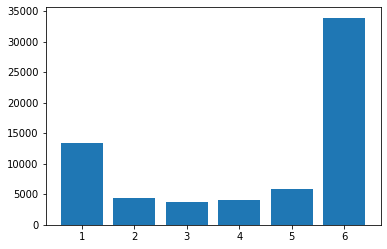

In [22]:
#Method 3: Rank Histogram
# !pip install rank-histogram
# R code: https://rdrr.io/cran/SpecsVerification/src/R/Rankhist.R
from ranky import rankz

obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

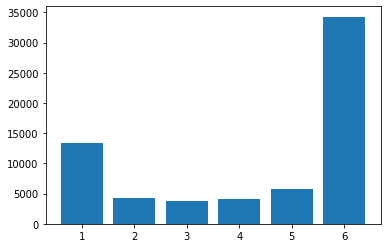

In [23]:
#result from old code with 50 forecasts. just to show it is still overconfident
result = rankz(obs_t850, pred_t850, mask)
plt.bar(range(1,pred_t850.shape[0]+2), result[0])
plt.show()

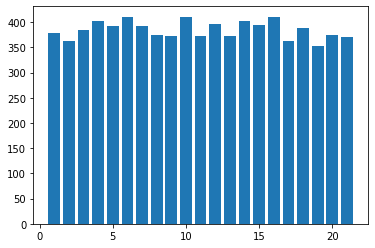

In [24]:
#sanity check: for a random sample
obs = np.random.randn(10, 40, 40)
ensemble = np.random.randn(20, 10, 40, 40)
mask = np.random.randint(0, 2, (10, 40, 40)) #masked where 0/false.
# feed into rankz function
result = rankz(obs, ensemble, mask)
# plot histogram
plt.bar(range(1,ensemble.shape[0]+2), result[0])
# view histogram
plt.show()

(32, 32, 64)
(5, 32, 32, 64)
(32, 32, 64)


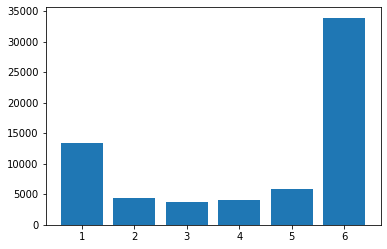

In [25]:
#testing for smaller number of bins (i.e. forecasts) (For old predictions.)
obs_small=obs_z500[:,:,:].squeeze()
pred_small=pred_z500[0:10,:,:,:]
mask=np.ones(obs_small.shape).squeeze()
print(obs_small.shape)
print(pred_small.shape)
print(mask.shape)

result = rankz(obs_small, pred_small, mask)
plt.bar(range(1,pred_small.shape[0]+2), result[0])
plt.show() #overconfident (underdispersive)